# 1D hydrogen in laser field

This notebook demonstrates basic use of the split-step Fourier routines on a 1D example, that of a 1D hydrogen-like atom in an external laser field. The nuclear potential is a gaussian well. The total Hamiltonian is thus
$$ H = -\frac{1}{2} \frac{\partial^2}{\partial x^2} + V(x) + E(t)x, $$
where
$$ V(x) = -e^{-0.1 x^2}, $$
and where $E(t)$ is a prescribed oscillating electric field. We are solving the time-dependent Schrödinger equation
$$ i \frac{\partial}{\partial t}\psi(x,t) = H(t) \psi(x,t), \quad \psi(x,0) = \psi_0(x), $$
for $t \in [0,t_\text{final}]$ using the split-step Fourier method.

In the second part, a 2D example is given, that of the hydrogen anion in 1D, with the same laser pulse as before. This demonstrates the capability of the toolbox to compute densities.

In [1]:
import numpy as np
from fft_tdse import *
from psiviz import *
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
%matplotlib inline

## Setup
First, we set up the grid parameters and the external potential.

Iteration 0, delta = 0.2612010189126773, resid = 0.05596390148490785, E = -0.7912650536115173
Iteration 1, delta = 0.05748285402360125, resid = 0.011794670639110213, E = -0.7950684429787886
Iteration 2, delta = 0.013102048066269422, resid = 0.002682735106244996, E = -0.7952562537145392
Iteration 3, delta = 0.0030806228312417853, resid = 0.0006307091907707043, E = -0.7952664182850457
Iteration 4, delta = 0.0007348876146239517, resid = 0.000150455783049356, E = -0.7952669912475574
Iteration 5, delta = 0.00017652001122896518, resid = 3.6139467960181965e-05, E = -0.7952670241541119
Iteration 6, delta = 4.2548044937041e-05, resid = 8.71098880630715e-06, E = -0.7952670260614645
Iteration 7, delta = 1.0274800223608882e-05, resid = 2.1035931144403227e-06, E = -0.7952670261725522
Iteration 8, delta = 2.4838165108401112e-06, resid = 5.085207128991625e-07, E = -0.7952670261790393
Iteration 9, delta = 6.007979694504474e-07, resid = 1.2300441541797424e-07, E = -0.7952670261794189
Iteration 10, delt

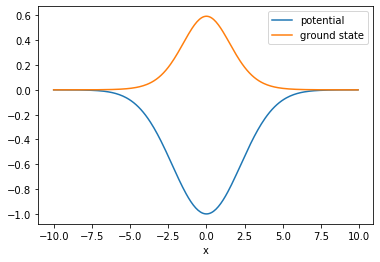

In [2]:
# Set up a fairly large grid
ng = 2048
L = 400
grid = FourierGrid([-L],[L],[ng])
t_final = 100

# Set up gaussian potential
Vfun0 = lambda x: -np.exp(-.1 * x**2)
Vfun = lambda xx: Vfun0(xx[0]) # the grid stores the nodes for each dimension in a list ...


# Fetch the nodes of the grid.
x = grid.x[0] 


def compute_ground_state(L2,ng2,Vfun):
    """ Compute ground state wavefunction on a suitable grid, 
    and then extrapolate to the computationa grid. """
    
    grid2 = FourierGrid([-L2],[L2],[ng2])
    x = grid2.x[0]
    
    ham = FourierHamiltonian(grid2, Vfun = Vfun)
        
    gs = GroundStateComputer(ham)
    gs.setInitialGuess(np.exp(-x**2/2))
    sigma = np.min(Vfun([x]))
    E = gs.invit(sigma = sigma)

    plt.figure()
    plt.plot(x,Vfun([x]),x,np.real(gs.wf.psi))
    plt.legend(['potential','ground state'])
    plt.xlabel('x')
    plt.show()
    
    
    return gs.wf.interpolate(grid).psi

# Compute ground state on a smaller grid, then extrapolate.
psi0 = compute_ground_state(10,256,Vfun)



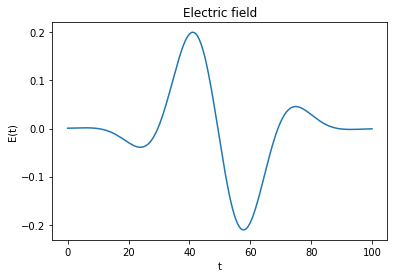

In [3]:
# Set up laser field
E0, tau, om, T = 0.25, 20.5, 1.0/(2*np.pi), 50

Efun = lambda t: E0*np.exp(-(t-T)**2/tau**2) * np.cos(om*t)

plt.figure()
t = np.linspace(0,t_final,200)
plt.plot(t,Efun(t))
plt.title('Electric field')
plt.xlabel('t')
plt.ylabel('E(t)')
plt.show()


In [4]:
def visualize(psi,heading):
    """ Visualize the wavefunction. """
    plt.figure()
    plt.plot(x,psi.real,'b',linewidth=.25)
    plt.plot(x,psi.imag,'r',linewidth=.25)
    plt.plot(x,np.abs(psi),'k',linewidth=.5)
    plt.legend(['Re','Im','abs'])
    plt.title(heading)
    plt.xlabel('x')
    plt.show()
    

# Set up initial condition and propagator

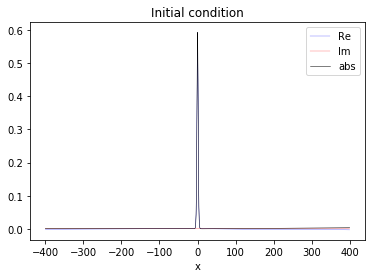

In [5]:
# Set up initial condition.
visualize(psi0,'Initial condition')

# Create a wavefunction object
wf = FourierWavefunction(grid)
wf.setPsi(psi0,normalize=True)

# Set up Hamiltonian
ham = FourierHamiltonian(grid, Vfun = Vfun, Efun=Efun)

# Create a Strang splitting propagator
dt = 0.01 
prop = Propagator(ham, dt)

# Main simulation loop

The propagation is here. We do a visualization once in a while.

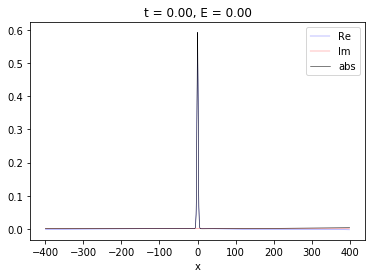

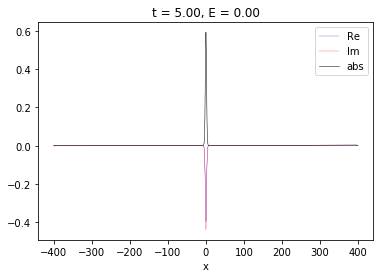

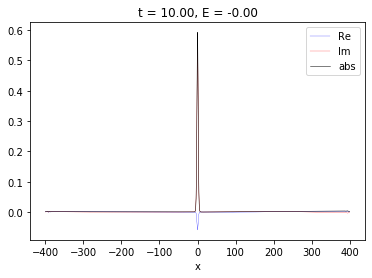

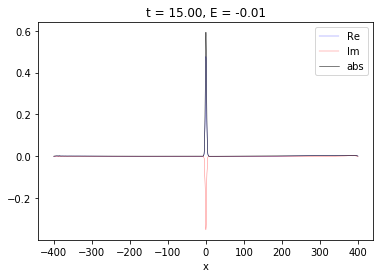

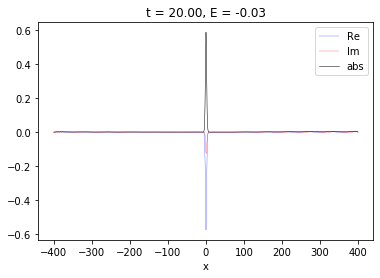

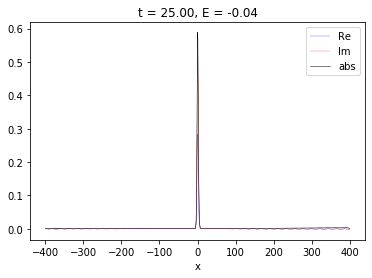

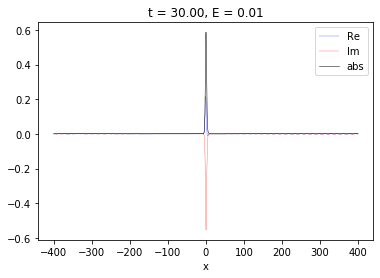

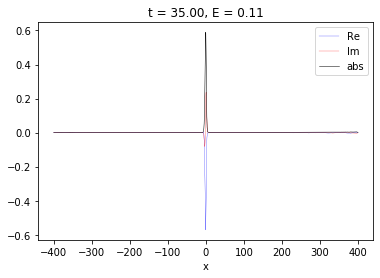

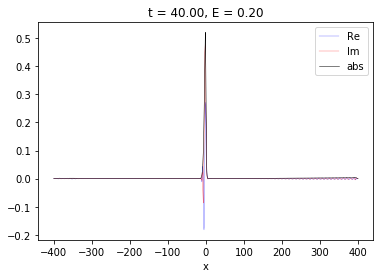

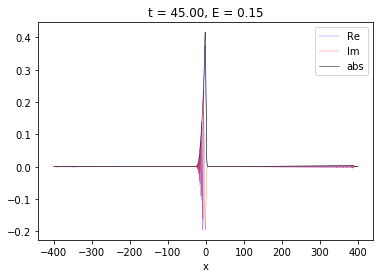

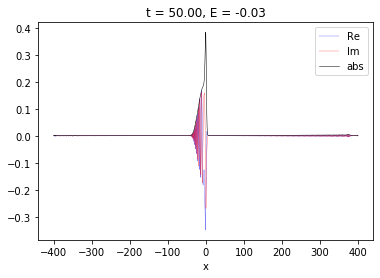

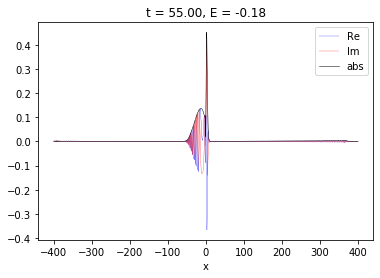

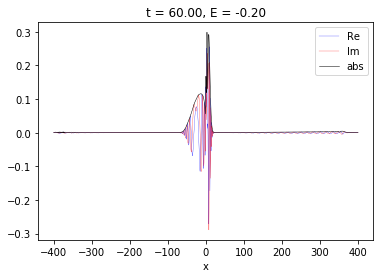

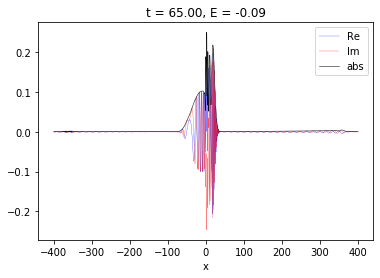

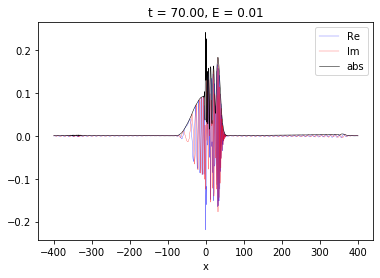

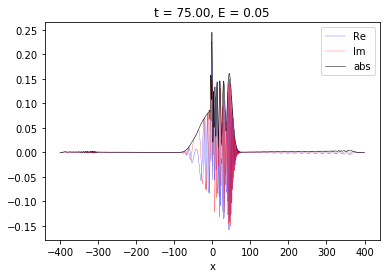

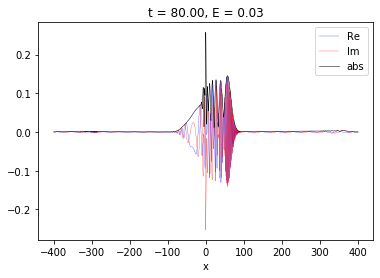

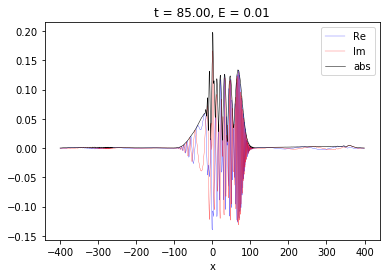

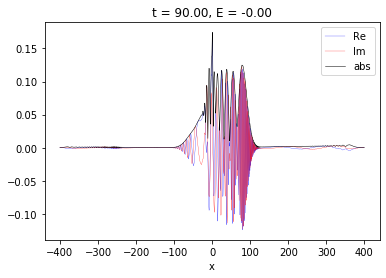

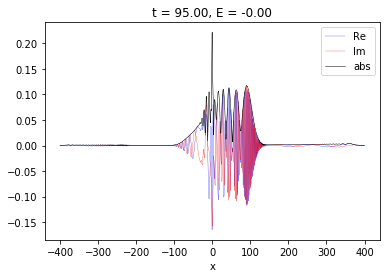

In [6]:
t_range = np.arange(0,t_final,dt)
psi_hist = np.zeros((len(x),len(t_range)), dtype=complex)
for i in range(len(t_range)):
    t = t_range[i]
    psi_hist[:,i] = wf.psi
    if i % int(t_final/20/dt) == 0:
        visualize(wf.psi,f't = {t:.2f}, E = {Efun(t):.2f}')
    prop.strang(wf,t)


## Visualize entire history

We visualize the entire history of the simulation. The colors represent the phase of the wavefunction.


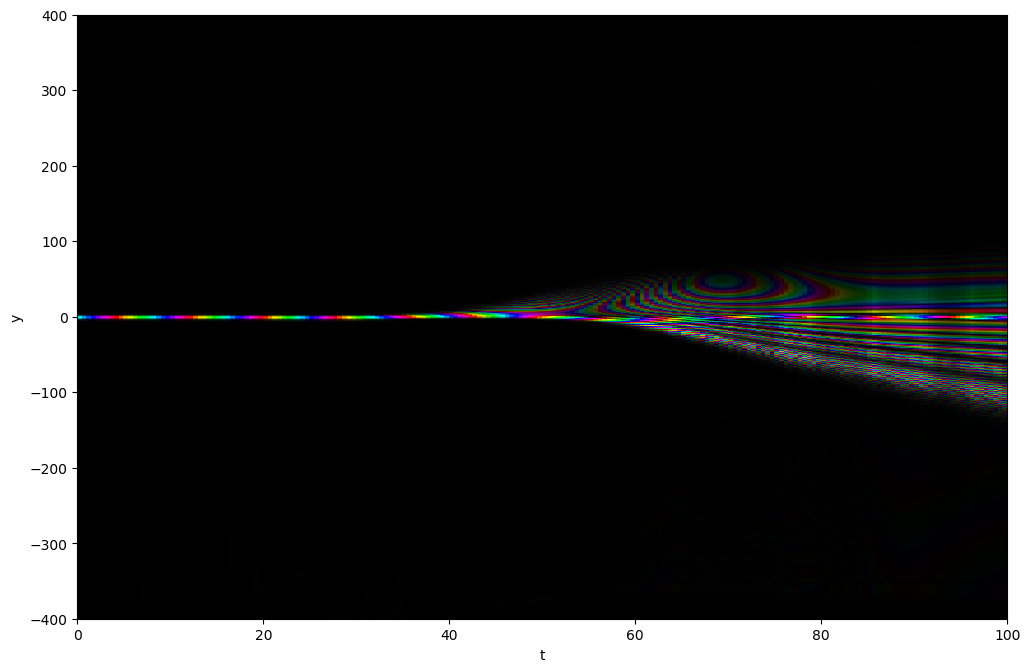

In [7]:
I = psiviz(psi_hist,normalize_columns=True)
fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
plt.imshow(I[::2,::50],aspect='auto',extent=[0,t_final,-L,L])
plt.xlabel('t')
plt.ylabel('y')
plt.show()

# Hydrogen anion example

Iteration 0, delta = 0.48442681504130025, resid = 0.20004972597917692, E = -0.8148542059893804
Iteration 1, delta = 0.2593438939397648, resid = 0.08136534177007461, E = -0.8847821074460546
Iteration 2, delta = 0.12653718257545862, resid = 0.03705825886944145, E = -0.8994450609280839
Iteration 3, delta = 0.06353457086748493, resid = 0.018302087241338028, E = -0.9029194543388811
Iteration 4, delta = 0.033427790037136765, resid = 0.009587926070409652, E = -0.9038434291021875
Iteration 5, delta = 0.018421554636338, resid = 0.005277213116560324, E = -0.9041152122168155
Iteration 6, delta = 0.01059489571278232, resid = 0.0030339287969066374, E = -0.9042026969463157
Iteration 7, delta = 0.0063286488140492725, resid = 0.0018120145300119803, E = -0.90423319598479
Iteration 8, delta = 0.0039052388864966752, resid = 0.0011180905269397884, E = -0.9042445860161723
Iteration 9, delta = 0.002476583315495501, resid = 0.0007090453000954605, E = -0.9042490938820621
Iteration 10, delta = 0.00160656319138

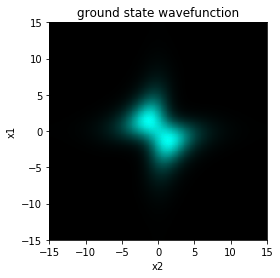

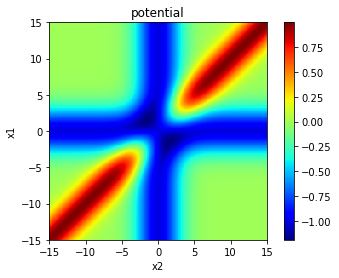

In [8]:
# Set up a fairly large grid
ng = 1024
L = 150
grid = FourierGrid([-L,-L],[L,L],[ng,ng])
t_final = 100

# Set up gaussian potential
Vfun0 = lambda x: -np.exp(-.1 * x**2)
Vfun = lambda xx: Vfun0(xx[0]) + Vfun0(xx[1]) - Vfun0(xx[0]-xx[1]) 

# Fetch the nodes of the grid.
x = grid.x[0] 


def compute_ground_state(L2,ng2,Vfun):
    """ Compute ground state wavefunction on a suitable grid, 
    and then extrapolate to the computationa grid. """
    
    grid2 = FourierGrid([-L2,-L2],[L2,L2],[ng2,ng2])
    x1 = grid2.xx[0]
    x2 = grid2.xx[1]
    
    ham = FourierHamiltonian(grid2, Vfun = Vfun)
        
    gs = GroundStateComputer(ham)
    gs.setInitialGuess(np.exp(-x1**2/2-x2**2/2))
    sigma = np.min(Vfun(grid2.xx))
    E = gs.invit(sigma = sigma)

    plt.figure()
    plt.imshow(psiviz(gs.wf.psi),origin='lower',extent=[-L2,L2,-L2,L2])
    plt.title('ground state wavefunction')
    plt.xlabel('x2')
    plt.ylabel('x1')
    plt.figure()
    plt.imshow(ham.V,origin='lower',extent=[-L2,L2,-L2,L2],cmap='jet')
    plt.colorbar()
    plt.title('potential')
    plt.xlabel('x2')
    plt.ylabel('x1')
    plt.show()
    
    
    return gs.wf.interpolate(grid).psi

# Compute ground state on a smaller grid, then extrapolate.
psi0 = compute_ground_state(15,256,Vfun)


In [9]:
def visualize(psi,heading):
    """ Visualize the wavefunction in 2D. """
    plt.figure()
    plt.imshow(psiviz(psi,ampmap = lambda u: u**.25),origin='lower',extent=[-L,L,-L,L])
    plt.xlabel('x2')
    plt.ylabel('x1')
    plt.title(heading)
    plt.show()
    

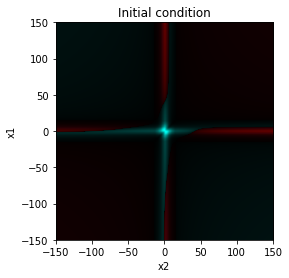

In [10]:
# Set up initial condition.
visualize(psi0,'Initial condition')

# Create a wavefunction object
wf = FourierWavefunction(grid)
wf.setPsi(psi0,normalize=True)

# Set up Hamiltonian
ham = FourierHamiltonian(grid, Vfun = Vfun, Efun=Efun)

# Create a Strang splitting propagator
dt = 0.01 
prop = Propagator(ham, dt)

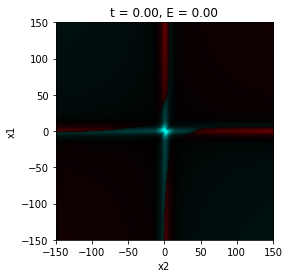

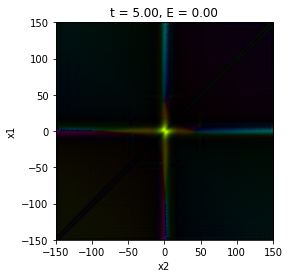

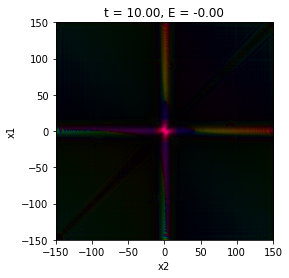

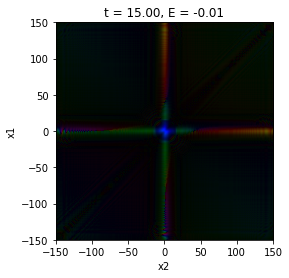

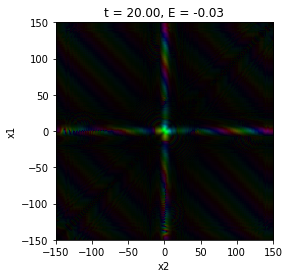

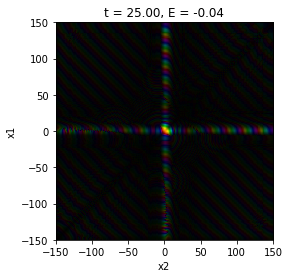

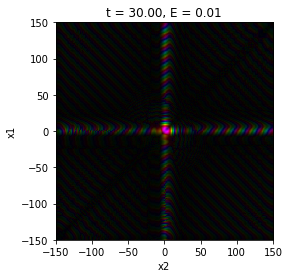

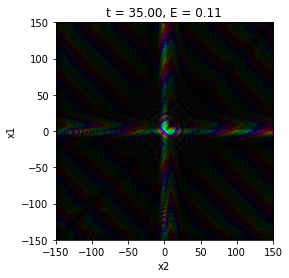

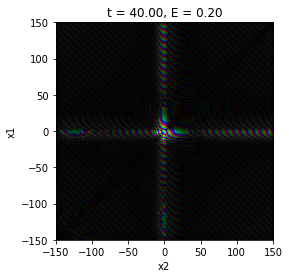

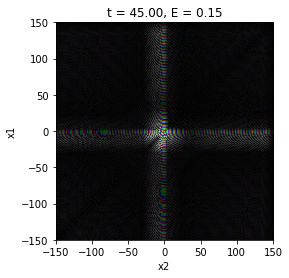

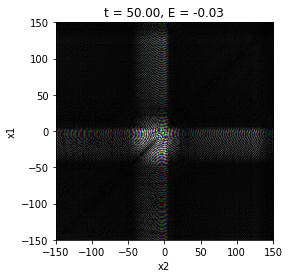

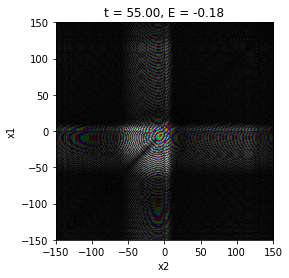

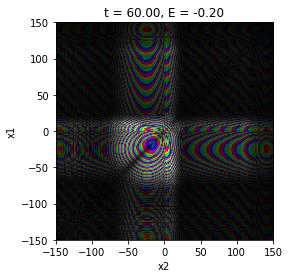

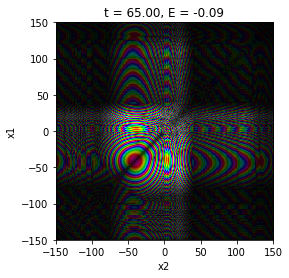

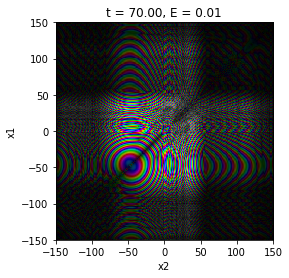

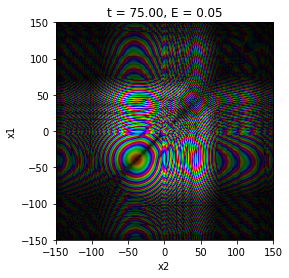

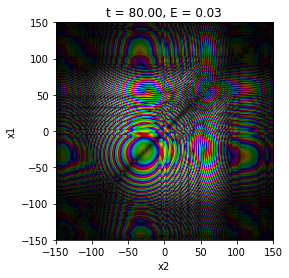

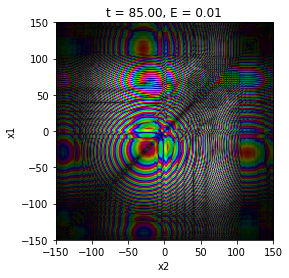

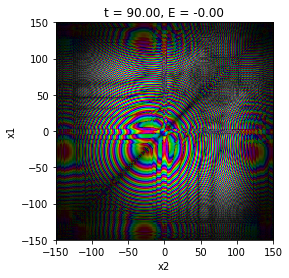

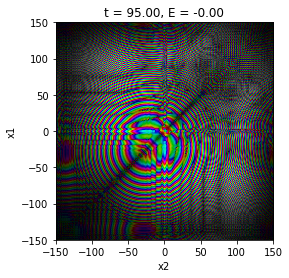

In [11]:
t_range = np.arange(0,t_final,dt)
dens_hist = np.zeros((len(x),len(t_range)), dtype=float)
curr_hist = np.zeros((len(x),len(t_range)), dtype=float)
for i in tqdm(range(len(t_range))):
    t = t_range[i]
    dens_hist[:,i] = wf.density(0)
    curr_hist[:,i] = wf.current(0) # current is not entirely corrext, must update fft of psi!!
    if i % int(t_final/20/dt) == 0:
        visualize(wf.psi,f't = {t:.2f}, E = {Efun(t):.2f}')
    prop.strang(wf,t) # add parameter will_do_another_step = False to force updating the fft of the wavefunction

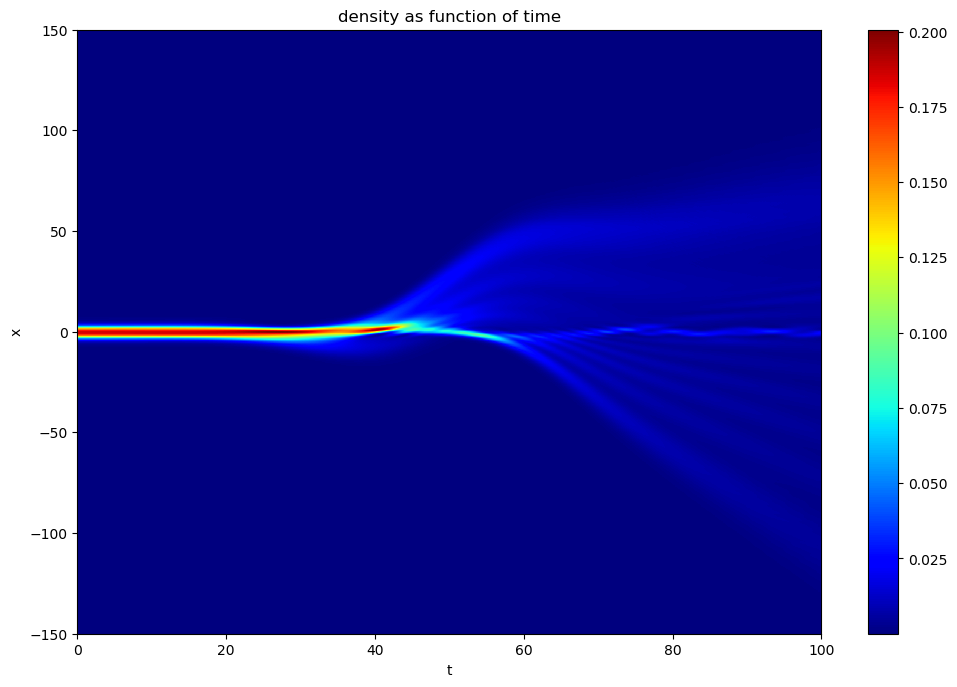

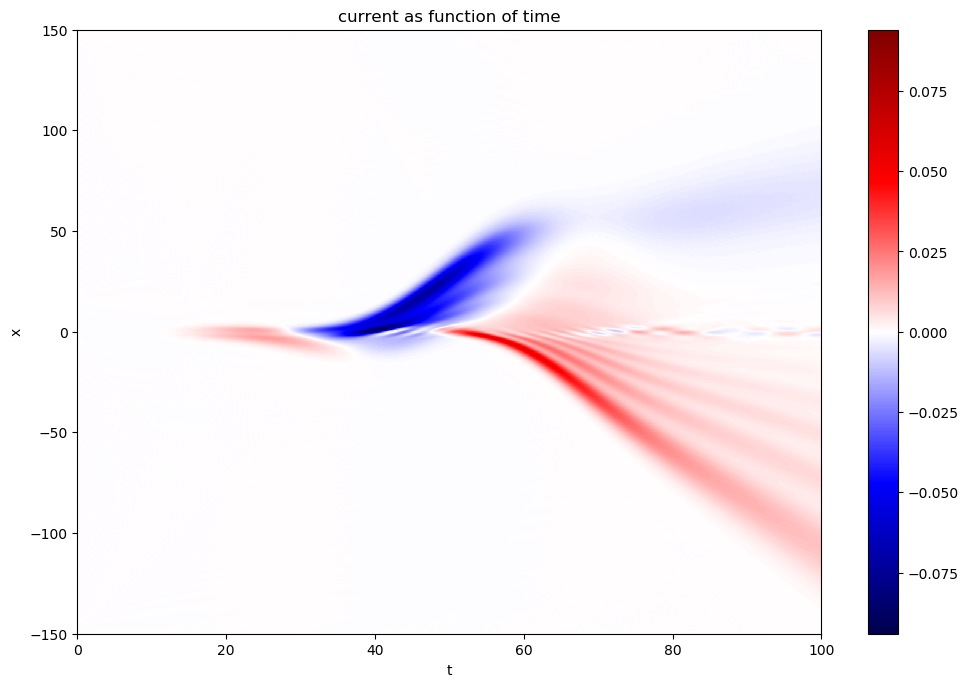

In [12]:
plt.figure(figsize=(12,8), dpi= 100)
plt.imshow(dens_hist,aspect='auto',extent=[0,t_final,-L,L],cmap='jet')
plt.colorbar()
plt.title('density as function of time')
plt.xlabel('t')
plt.ylabel('x')
plt.figure(figsize=(12,8), dpi= 100)
bound = np.max(np.abs(curr_hist))
plt.imshow(curr_hist,vmin=-bound,vmax=bound,aspect='auto',extent=[0,t_final,-L,L],cmap='seismic')
plt.xlabel('t')
plt.ylabel('x')
plt.colorbar()
plt.title('current as function of time')
plt.show()